In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import sys
from bs4 import BeautifulSoup
import re
import unicodedata
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
from geopy.distance import geodesic

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
%matplotlib inline

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

print('Working environment is ready')

Working environment is ready


# Part 1: Data collection 

From [SpaceX API on GitHub](https://github.com/r-spacex/SpaceX-API/)

From the `rocket` column we would like to learn the booster name.

In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the `launchpad` we would like to know the name of the launch site being used, the logitude, and the latitude.

In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the `payload` we would like to learn the mass of the payload and the orbit that it is going to.

In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From `cores` we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [6]:
# Requesting rocket launch data from SpaceX API
spacex_url="https://api.spacexdata.com/v4/launches/past"
response=requests.get(spacex_url)
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

### Task 1: Request and parse the SpaceX launch data using the GET request

To make the requested JSON results more consistent, we will use the following static response object for this project:

In [7]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

# Get response from API
response=requests.get(static_json_url)

# Get static code
response.status_code

200

In [8]:
# Get content of response in dataframe
data=pd.json_normalize(response.json())
data.head()

static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                                                                                                                                                                details  \
0                                                                                                                                      Engine failure at 33 seconds and loss of vehicle   
1  Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage   
2                                                                                                                  Residual stage 1 thrust led to collision between stage 1 and stage 2   
3                        Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1   
4                                                                                                                                                                                  None   

  crew ships capsules                                              payloads  \
0   []    []       []                            [5eb0e4b5b6c3bb0006eeb1e1]   
1   []    []       []                            [5eb0e4b6b6c3bb0006eeb1e2]   
2   []    []       []  [5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]   
3   []    []       []                            [5eb0e4b7b6c3bb0006eeb1e5]   
4   []    []       []                            [5eb0e4b7b6c3bb0006eeb1e6]   

                  launchpad  auto_update  \
0  5e9e4502f5090995de566f86         True   
1  5e9e4502f5090995de566f86         True   
2  5e9e4502f5090995de566f86         True   
3  5e9e4502f5090995de566f86         True   
4  5e9e4502f5090995de566f86         True   

                                                                                                            failures  \
0                                                [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]   
1            [{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]   
2  [{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]   
3                                                                                                                 []   
4                                                                                                                 []   

   flight_number         name                  date_utc   date_unix  \
0              1    FalconSat  2006-03-24T22:30:00.000Z  1143239400   
1              2      DemoSat  2007-03-21T01:10:00.000Z  1174439400   
2              3  Trailblazer  2008-08-03T03:34:00.000Z  1217734440   
3              4       RatSat  2008-09-28T23:15:00.000Z  1222643700   
4              5     RazakSat  2009-07-13T03:35:00.000Z  1247456100   

                  date_local date_precision  upcoming  \
0  2006-03-25T10:30:00+12:00           hour     False   
1  2007-03-21T13:10:00+12:00           hour     False   
2  2008-08-03T15:34:00+12:00           hour     False   
3  2008-09-28T11:15:00+12:00           hour     False   
4  2009-07-13

In [9]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* **From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.**

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [10]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [11]:
# Call getBoosterVersion and other function
# Call getBoosterVersion
getBoosterVersion(data)

In [12]:
# Call getLaunchSite
getLaunchSite(data)

In [13]:
# Call getCoreData
getCoreData(data)

In [14]:
# Call getPayloadData
getPayloadData(data)

In [16]:
# Construct dictionary of the data we extracted

launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [17]:
# Create a dataframe
df=pd.DataFrame(launch_dict)
df.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit  \
0             1  2006-03-24       Falcon 1         20.0   LEO   
1             2  2007-03-21       Falcon 1          NaN   LEO   
2             4  2008-09-28       Falcon 1        165.0   LEO   
3             5  2009-07-13       Falcon 1        200.0   LEO   
4             6  2010-06-04       Falcon 9          NaN   LEO   

        LaunchSite    Outcome  Flights  GridFins  Reused   Legs LandingPad  \
0  Kwajalein Atoll  None None        1     False   False  False       None   
1  Kwajalein Atoll  None None        1     False   False  False       None   
2  Kwajalein Atoll  None None        1     False   False  False       None   
3  Kwajalein Atoll  None None        1     False   False  False       None   
4     CCSFS SLC 40  None None        1     False   False  False       None   

   Block  ReusedCount    Serial   Longitude   Latitude  
0    NaN            0  Merlin1A  167.743129   9.047721  
1    NaN            0  Merlin2A  167.743129   9.047721  
2    NaN            0  Merlin2C  167.743129   9.047721  
3    NaN            0  Merlin3C  167.743129   9.047721  
4    1.0            0     B0003  -80.577366  28.561857

In [19]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    94 non-null     int64  
 1   Date            94 non-null     object 
 2   BoosterVersion  94 non-null     object 
 3   PayloadMass     88 non-null     float64
 4   Orbit           94 non-null     object 
 5   LaunchSite      94 non-null     object 
 6   Outcome         94 non-null     object 
 7   Flights         94 non-null     int64  
 8   GridFins        94 non-null     bool   
 9   Reused          94 non-null     bool   
 10  Legs            94 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     94 non-null     int64  
 14  Serial          94 non-null     object 
 15  Longitude       94 non-null     float64
 16  Latitude        94 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

In [22]:
# Filter dataset to include only Falcon9 launches
df=df[df['BoosterVersion']=='Falcon 9']
df.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4             6  2010-06-04       Falcon 9          NaN   LEO  CCSFS SLC 40   
5             8  2012-05-22       Falcon 9        525.0   LEO  CCSFS SLC 40   
6            10  2013-03-01       Falcon 9        677.0   ISS  CCSFS SLC 40   
7            11  2013-09-29       Falcon 9        500.0    PO   VAFB SLC 4E   
8            12  2013-12-03       Falcon 9       3170.0   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
4    None None        1     False   False  False       None    1.0   
5    None None        1     False   False  False       None    1.0   
6    None None        1     False   False  False       None    1.0   
7  False Ocean        1     False   False  False       None    1.0   
8    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  
4            0  B0003  -80.577366  28.561857  
5            0  B0005  -80.577366  28.561857  
6            0  B0007  -80.577366  28.561857  
7            0  B1003 -120.610829  34.632093  
8            0  B1004  -80.577366  28.561857

In [24]:
# Reset flight number column
df.loc[:, 'FlightNumber']=list(range(1,df.shape[0]+1))
df.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4             1  2010-06-04       Falcon 9          NaN   LEO  CCSFS SLC 40   
5             2  2012-05-22       Falcon 9        525.0   LEO  CCSFS SLC 40   
6             3  2013-03-01       Falcon 9        677.0   ISS  CCSFS SLC 40   
7             4  2013-09-29       Falcon 9        500.0    PO   VAFB SLC 4E   
8             5  2013-12-03       Falcon 9       3170.0   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
4    None None        1     False   False  False       None    1.0   
5    None None        1     False   False  False       None    1.0   
6    None None        1     False   False  False       None    1.0   
7  False Ocean        1     False   False  False       None    1.0   
8    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  
4            0  B0003  -80.577366  28.561857  
5            0  B0005  -80.577366  28.561857  
6            0  B0007  -80.577366  28.561857  
7            0  B1003 -120.610829  34.632093  
8            0  B1004  -80.577366  28.561857

# Data Wrangling

In [25]:
# Exploring missing values
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [26]:
# Replace missing values in payload mass with average
plmean=df.PayloadMass.mean()
df['PayloadMass'].replace(np.nan, plmean, inplace=True)
df.isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_15804\2382213045.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PayloadMass'].replace(np.nan, plmean, inplace=True)


FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [29]:
# Explort dataset into csv format
path=r'C:\Users\USER\OneDrive - University of Global Health Equity\Documents\PERSONAL DOCUMENTS\PERSONAL DEVELOPMENT\IBM DATA SCIENCE\Key projects\Applied Data Science Capstone\Falcon9Launch.csv'
df.to_csv(path, index=False)
print('File saved successfuly')

File saved successfuly


# Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia

Supporting function for web scrapping

In [31]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


In [32]:
# Scrap from wikipage updated 9th june 2021

static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

In [36]:
response=requests.get(static_url, headers=headers)

# Create Beautiful soup object
soup=BeautifulSoup(response.text, 'html.parser')
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

### TASK 2: Extract all column/variable names from the HTML table header

In [38]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`

html_tables=soup.find_all('table')
html_tables

[<table class="col-begin" role="presentation">
 <tbody><tr>
 <td class="col-break">
 <div class="mw-heading mw-heading3"><h3 id="Rocket_configurations">Rocket configurations</h3></div>
 <div class="chart noresize" style="padding-top:10px;margin-top:1em;max-width:420px;">
 <div style="position:relative;min-height:320px;min-width:420px;max-width:420px;">
 <div style="float:right;position:relative;min-height:240px;min-width:320px;max-width:320px;border-left:1px black solid;border-bottom:1px black solid;">
 <div style="position:absolute;left:3px;top:224px;height:15px;min-width:18px;max-width:18px;color:inherit;background-color:LightSteelBlue;-webkit-print-color-adjust:exact;border:1px solid LightSteelBlue;border-bottom:none;overflow:hidden;" title="[[Falcon 9 v1.0]]: 2"></div>
 <div style="position:absolute;left:55px;top:224px;height:15px;min-width:18px;max-width:18px;color:inherit;background-color:LightSteelBlue;-webkit-print-color-adjust:exact;border:1px solid LightSteelBlue;border-botto

In [40]:
# Starting from third table is target for our actual launch records
first_launch_table=html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 


Next, we just need to iterate through the <th> elements and apply the provided extract_column_from_header() to extract column name one by one

In [45]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

# Find all <th> elements in the table
for th in first_launch_table.find_all('th'):
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
        column_names.append(name)

In [46]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


### TASK 3: Create a data frame by parsing the launch HTML tables

We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe

In [59]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the launch_dict. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:

In [60]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            print(launch_dict['Flight No.'])
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            #print(date)
            print(launch_dict['Date'])
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            #print(time)
            print(launch_dict['Time'])
            
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            print(bv)
            launch_dict['Version Booster'].append(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            #print(launch_site)
            print(launch_dict['Launch site'])
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            #print(payload)
            print(launch_dict['Payload'])
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            #print(payload)
            print(launch_dict['Payload mass'])
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            #print(orbit)
            print(launch_dict['Orbit'])
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a:
                customer = row[6].a.string
            else:
                customer = row[6].get_text(strip=True)  # fallback to plain text
            launch_dict['Customer'].append(customer)
            #print(customer)
            print(launch_dict['Customer'])
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            #print(launch_outcome)
            print(launch_dict['Launch outcome'])
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            #print(booster_landing)
            print(launch_dict['Booster landing'])

['1']
['4 June 2010']
['18:45']
F9 v1.07B0003.18
['CCAFS']
['Dragon Spacecraft Qualification Unit']
[0]
['LEO']
['SpaceX']
['Success\n']
['Failure']
['1', '2']
['4 June 2010', '8 December 2010']
['18:45', '15:43']
F9 v1.07B0004.18
['CCAFS', 'CCAFS']
['Dragon Spacecraft Qualification Unit', 'Dragon']
[0, 0]
['LEO', 'LEO']
['SpaceX', 'NASA']
['Success\n', 'Success']
['Failure', 'Failure']
['1', '2', '3']
['4 June 2010', '8 December 2010', '22 May 2012']
['18:45', '15:43', '07:44']
F9 v1.07B0005.18
['CCAFS', 'CCAFS', 'CCAFS']
['Dragon Spacecraft Qualification Unit', 'Dragon', 'Dragon']
[0, 0, '525 kg']
['LEO', 'LEO', 'LEO']
['SpaceX', 'NASA', 'NASA']
['Success\n', 'Success', 'Success']
['Failure', 'Failure', 'No\xa0attempt\n']
['1', '2', '3', '4']
['4 June 2010', '8 December 2010', '22 May 2012', '8 October 2012']
['18:45', '15:43', '07:44', '00:35']
F9 v1.07B0006.18
['CCAFS', 'CCAFS', 'CCAFS', 'CCAFS']
['Dragon Spacecraft Qualification Unit', 'Dragon', 'Dragon', 'SpaceX CRS-1']
[0, 0, '5

In [61]:
# Create a dataframe
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df.head()

Flight No. Launch site                               Payload Payload mass  \
0          1       CCAFS  Dragon Spacecraft Qualification Unit            0   
1          2       CCAFS                                Dragon            0   
2          3       CCAFS                                Dragon       525 kg   
3          4       CCAFS                          SpaceX CRS-1     4,700 kg   
4          5       CCAFS                          SpaceX CRS-2     4,877 kg   

  Orbit Customer Launch outcome   Version Booster Booster landing  \
0   LEO   SpaceX      Success\n  F9 v1.07B0003.18         Failure   
1   LEO     NASA        Success  F9 v1.07B0004.18         Failure   
2   LEO     NASA        Success  F9 v1.07B0005.18    No attempt\n   
3   LEO     NASA      Success\n  F9 v1.07B0006.18      No attempt   
4   LEO     NASA      Success\n  F9 v1.07B0007.18    No attempt\n   

              Date   Time  
0      4 June 2010  18:45  
1  8 December 2010  15:43  
2      22 May 2012  07:44  
3   8 October 2012  00:35  
4     1 March 2013  15:10

In [62]:
df.shape

(121, 11)

In [63]:
# Save dataframe
path=r'C:\Users\USER\OneDrive - University of Global Health Equity\Documents\PERSONAL DOCUMENTS\PERSONAL DEVELOPMENT\IBM DATA SCIENCE\Key projects\Applied Data Science Capstone\spacex_web_scraped.csv'
df.to_csv(path, index=False)

print('spacex_web_scraped.csv saved successifully')

spacex_web_scraped.csv saved successifully


# Data Wrangling

### Data analysis

In [4]:
# Import dataset part 1
url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv'
df=pd.read_csv(url)
df.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  
0            0  B0003  -80.577366  28.561857  
1            0  B0005  -80.577366  28.561857  
2            0  B0007  -80.577366  28.561857  
3            0  B1003 -120.610829  34.632093  
4            0  B1004  -80.577366  28.561857

In [8]:
# Explore the percentage of missing values
np.round(df.isnull().sum()*100/len(df),2)

FlightNumber       0.00
Date               0.00
BoosterVersion     0.00
PayloadMass        0.00
Orbit              0.00
LaunchSite         0.00
Outcome            0.00
Flights            0.00
GridFins           0.00
Reused             0.00
Legs               0.00
LandingPad        28.89
Block              0.00
ReusedCount        0.00
Serial             0.00
Longitude          0.00
Latitude           0.00
dtype: float64

In [9]:
# Identify columns datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

In [12]:
# Calculate number of launches on each site
df.LaunchSite.value_counts().reset_index()

LaunchSite  count
0  CCAFS SLC 40     55
1    KSC LC 39A     22
2   VAFB SLC 4E     13

In [13]:
# Number and occurence of each orbit
df.Orbit.value_counts().reset_index()

Orbit  count
0     GTO     27
1     ISS     21
2    VLEO     14
3      PO      9
4     LEO      7
5     SSO      5
6     MEO      3
7     HEO      1
8   ES-L1      1
9      SO      1
10    GEO      1

In [16]:
# Calculate the number and occurence of mission outcome
landing_outcomes=df.Outcome.value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [17]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [19]:
# Create a set of outcome where first stage did not land successfully
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [25]:
# Create a landing outcome label from outcome column
landing_class = [
    0 if outcome in bad_outcomes else 1
    for outcome in df.Outcome
]

df['class'] = landing_class
df['class'].value_counts().reset_index()   

class  count
0      1     60
1      0     30

In [26]:
df.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  class  
0            0  B0003  -80.577366  28.561857      0  
1            0  B0005  -80.577366  28.561857      0  
2            0  B0007  -80.577366  28.561857      0  
3            0  B1003 -120.610829  34.632093      0  
4            0  B1004  -80.577366  28.561857      0

In [23]:
list(landing_outcomes.keys())

['True ASDS',
 'None None',
 'True RTLS',
 'False ASDS',
 'True Ocean',
 'False Ocean',
 'None ASDS',
 'False RTLS']

In [27]:
# Explort dataset into csv format
path=r'C:\Users\USER\OneDrive - University of Global Health Equity\Documents\PERSONAL DOCUMENTS\PERSONAL DEVELOPMENT\IBM DATA SCIENCE\Key projects\Applied Data Science Capstone\Falcon9Launch.csv'
df.to_csv(path, index=False)
print('File saved successfuly')

File saved successfuly


# Assignment: SQL Notebook for Peer Assignment

In [32]:
# Import/Download libraries
!pip install sqlalchemy
!pip install ipython-sql
!pip install ipython-sql prettytable


   ---------- ----------------------------- 1/4 [sqlparse]
   -------------------- ------------------- 2/4 [prettytable]
   ------------------------------ --------- 3/4 [ipython-sql]
   ---------------------------------------- 4/4 [ipython-sql]



In [33]:
# Load sql extensions and establish connection with the database
%load_ext sql
import csv, sqlite3
import prettytable
prettytable.DEFAULT='DEFAULT'

con=sqlite3.connect('my_data1.db')
cur=con.cursor()
%sql sqlite:///my_data1.db

# Load dataset to created database
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [46]:
# Drop the table if exist
%sql drop table if exist SPAEXTABLE;
%sql create table SPAEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
(sqlite3.OperationalError) near "exist": syntax error
[SQL: drop table if exist SPAEXTABLE;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
 * sqlite:///my_data1.db
(sqlite3.OperationalError) table SPAEXTABLE already exists
[SQL: create table SPAEXTABLE as select * from SPACEXTBL where Date is not null]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [47]:
%sql select * from SPAEXTABLE limit 5

 * sqlite:///my_data1.db
Done.


[('2010-06-04', '18:45:00', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', 0, 'LEO', 'SpaceX', 'Success', 'Failure (parachute)'),
 ('2010-12-08', '15:43:00', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats, barrel of Brouere cheese', 0, 'LEO (ISS)', 'NASA (COTS) NRO', 'Success', 'Failure (parachute)'),
 ('2012-05-22', '7:44:00', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2', 525, 'LEO (ISS)', 'NASA (COTS)', 'Success', 'No attempt'),
 ('2012-10-08', '0:35:00', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', 500, 'LEO (ISS)', 'NASA (CRS)', 'Success', 'No attempt'),
 ('2013-03-01', '15:10:00', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', 677, 'LEO (ISS)', 'NASA (CRS)', 'Success', 'No attempt')]

#### Task 1¶
Display the names of the unique launch sites in the space mission

In [48]:
%sql select distinct "Launch_Site" from SPAEXTABLE

 * sqlite:///my_data1.db
Done.


[('CCAFS LC-40',), ('VAFB SLC-4E',), ('KSC LC-39A',), ('CCAFS SLC-40',)]

In [49]:
# Select 5 records where launch sites begin with 'CCA'
%sql select * from SPAEXTABLE where "Launch_Site" like 'CCA%' limit 5

 * sqlite:///my_data1.db
Done.


[('2010-06-04', '18:45:00', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', 0, 'LEO', 'SpaceX', 'Success', 'Failure (parachute)'),
 ('2010-12-08', '15:43:00', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats, barrel of Brouere cheese', 0, 'LEO (ISS)', 'NASA (COTS) NRO', 'Success', 'Failure (parachute)'),
 ('2012-05-22', '7:44:00', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2', 525, 'LEO (ISS)', 'NASA (COTS)', 'Success', 'No attempt'),
 ('2012-10-08', '0:35:00', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', 500, 'LEO (ISS)', 'NASA (CRS)', 'Success', 'No attempt'),
 ('2013-03-01', '15:10:00', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', 677, 'LEO (ISS)', 'NASA (CRS)', 'Success', 'No attempt')]

In [56]:
# Display total payload mass carried by boosters launched by NASA(CRS)

%sql select sum("PAYLOAD_MASS__KG_") from SPAEXTABLE where Customer = 'NASA (CRS)'


 * sqlite:///my_data1.db
Done.


[(45596,)]

In [60]:
# Display average payload mass carried by booster version F9 V1.1
%sql select avg("PAYLOAD_MASS__KG_") as F9V11_avg_payload from SPAEXTABLE where  "Booster_Version" like 'F9%v1.1%'

 * sqlite:///my_data1.db
Done.


[(2534.6666666666665,)]

In [64]:
# List the date when the first succesful landing outcome in ground pad was acheived.
%sql select min(Date) as First_successful_ground_landing from SPAEXTABLE where "Landing_Outcome"='Success (ground pad)'

 * sqlite:///my_data1.db
Done.


[('2015-12-22',)]

In [68]:
# List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000
%sql select distinct("Booster_Version") from SPAEXTABLE where Landing_Outcome='Success (drone ship)' and PAYLOAD_MASS__KG_ between 4001 and 5009

 * sqlite:///my_data1.db
Done.


[('F9 FT B1022',), ('F9 FT B1026',)]

In [69]:
# List the total number of successful and failure mission outcomes
%sql select Mission_Outcome, count(*) as Total from SPAEXTABLE group by Mission_Outcome

 * sqlite:///my_data1.db
Done.


[('Failure (in flight)', 1),
 ('Success', 98),
 ('Success ', 1),
 ('Success (payload status unclear)', 1)]

In [70]:
# List all the booster_versions that have carried the maximum payload mass, using a subquery with a suitable aggregate function.
%sql select "Booster_Version" from SPAEXTABLE where PAYLOAD_MASS__KG_=(select max("PAYLOAD_MASS__KG_") from SPAEXTABLE)

 * sqlite:///my_data1.db
Done.


[('F9 B5 B1048.4',),
 ('F9 B5 B1049.4',),
 ('F9 B5 B1051.3',),
 ('F9 B5 B1056.4',),
 ('F9 B5 B1048.5',),
 ('F9 B5 B1051.4',),
 ('F9 B5 B1049.5',),
 ('F9 B5 B1060.2 ',),
 ('F9 B5 B1058.3 ',),
 ('F9 B5 B1051.6',),
 ('F9 B5 B1060.3',),
 ('F9 B5 B1049.7 ',)]

In [80]:
# List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015
%sql select substr(Date,6,2) as Month, "Landing_Outcome", "Booster_Version", "Launch_Site" from SPAEXTABLE where substr(Date, 1, 4)='2015' and "Landing_Outcome" like '%Failure%' and "Landing_Outcome" like '%drone ship%';

 * sqlite:///my_data1.db
Done.


[('01', 'Failure (drone ship)', 'F9 v1.1 B1012', 'CCAFS LC-40'),
 ('04', 'Failure (drone ship)', 'F9 v1.1 B1015', 'CCAFS LC-40')]

In [83]:
# Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad)) between the date 2010-06-04 and 2017-03-20, in descending order.
%sql select "Landing_Outcome", count(*) as Outcome_Count from SPAEXTABLE where Date between '2010-06-04' and '2017-03-20' group by Landing_Outcome order by Outcome_Count desc

 * sqlite:///my_data1.db
Done.


[('No attempt', 10),
 ('Success (drone ship)', 5),
 ('Failure (drone ship)', 5),
 ('Success (ground pad)', 3),
 ('Controlled (ocean)', 3),
 ('Uncontrolled (ocean)', 2),
 ('Failure (parachute)', 2),
 ('Precluded (drone ship)', 1)]

# Exploratory data analysis and visualization

### Exploratory data analysis

In [119]:
# Import dataset
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df=pd.read_csv(URL)
df.head(5)

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

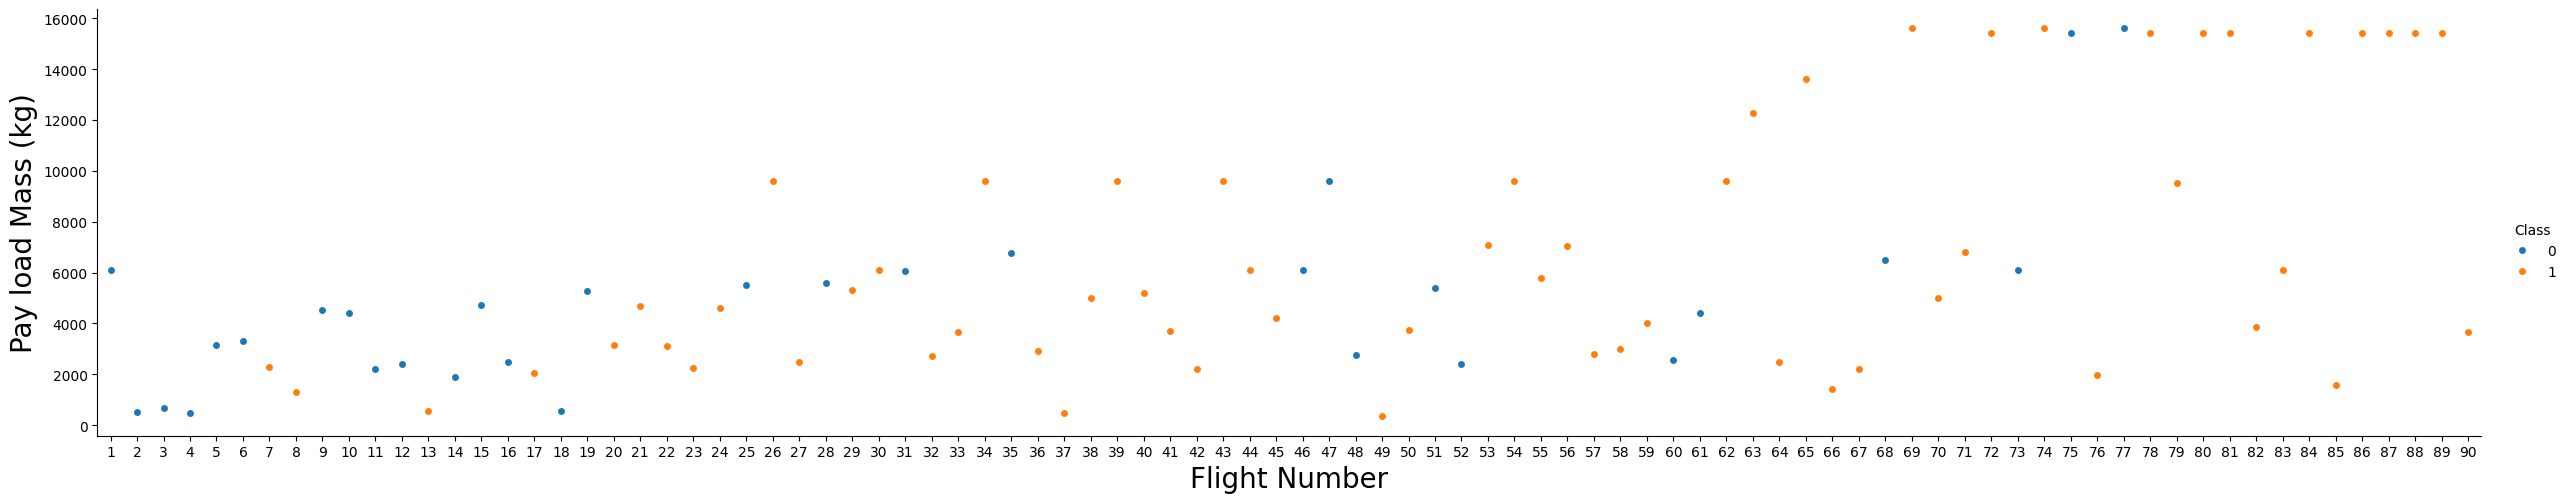

In [86]:
# How does FlightNumber and Payload affect the launch outcome
sns.catplot(y='PayloadMass', x='FlightNumber', hue='Class', data=df, aspect=5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

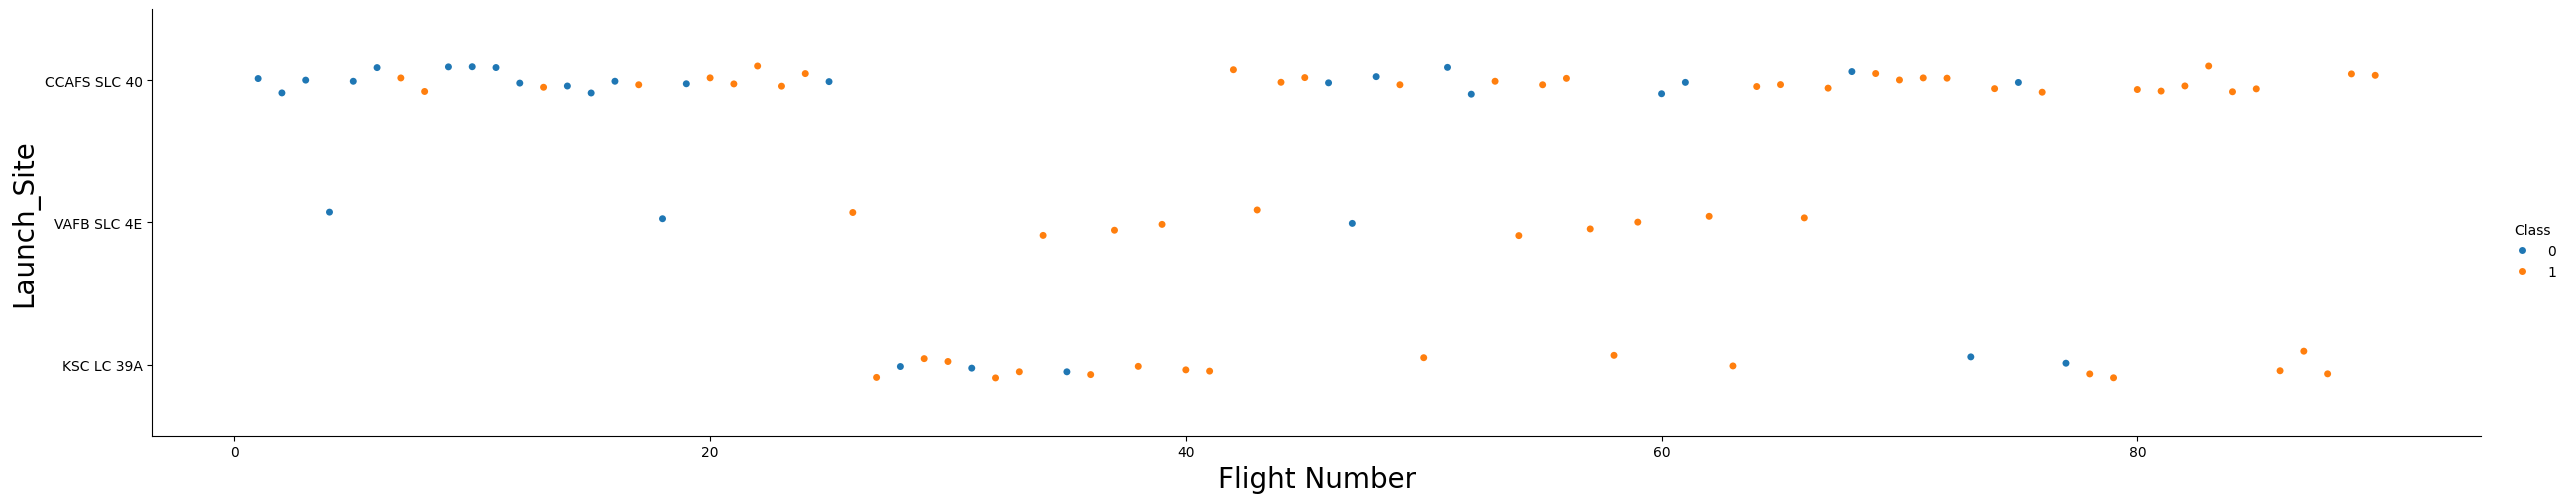

In [92]:
# Visualize the relationship between Flight Number and Launchsite
sns.catplot(y='LaunchSite', x='FlightNumber', hue='Class', data=df, aspect=5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch_Site",fontsize=20)
plt.show()

Again the launch success appear to be influenced by flight number. The Sattelite launched in **VAFB SLC 4E** were more likely to land. There is a mix in success of sattelite launched at **CCAFS SLC 40** however, the success rate evolved with flight number/time

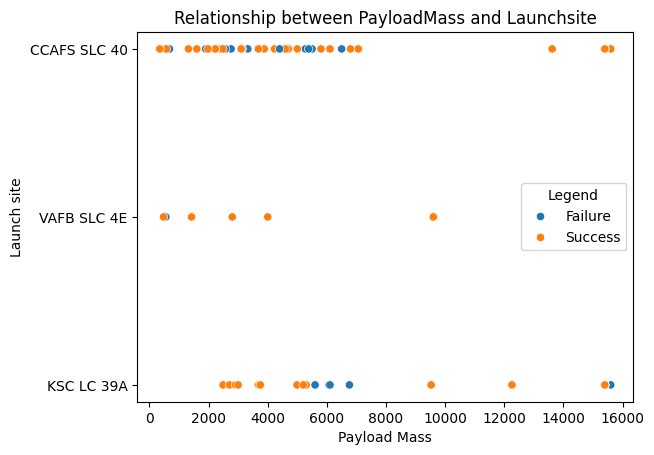

In [106]:
# Visualize the relationship between Payload Mass and Launch Site using scatter
sns.scatterplot(y='LaunchSite', x='PayloadMass', hue='Class', data=df)
plt.title('Relationship between PayloadMass and Launchsite')
plt.xlabel('Payload Mass')
plt.ylabel('Launch site')
# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = ['Failure', 'Success']  # Assuming 0 = Failure, 1 = Success
plt.legend(title='Legend', handles=handles, labels=custom_labels, loc='best')  # Skip automatic title

plt.show()

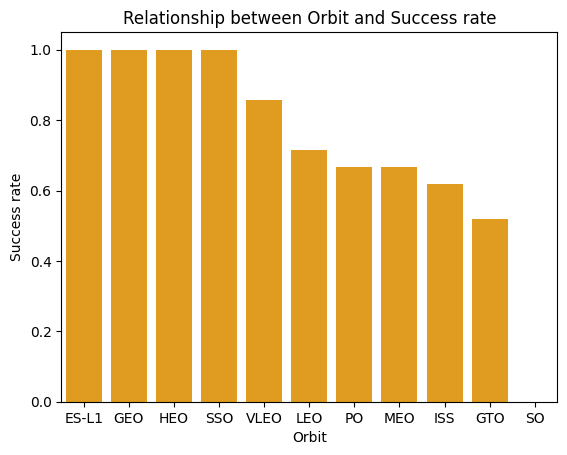

In [112]:
# Relationship between Success rate and obit type
data=df.groupby('Orbit')['Class'].mean().sort_values(ascending=False).reset_index()
sns.barplot(y='Class', x='Orbit', data=data, color='orange')
plt.title('Relationship between Orbit and Success rate')
plt.ylabel('Success rate')
plt.xlabel('Orbit')
plt.show()


**ES-L1**, **GEO**, **HEO**, and **SSO** has success rate of 100% while **SO** has success rate of 0.0%

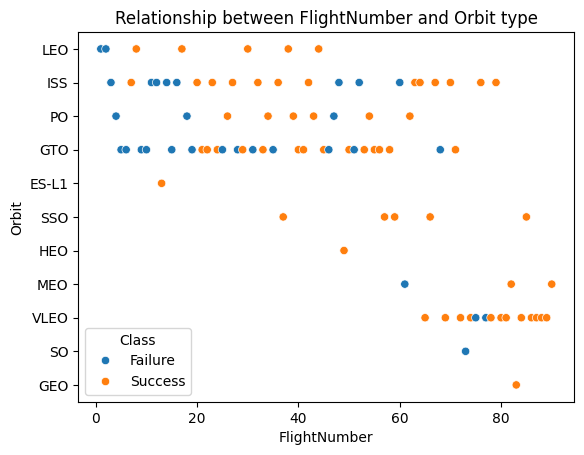

In [115]:
# Relationship between FlightNumber and Orbit type
sns.scatterplot(y='Orbit', x='FlightNumber', hue='Class', data=df)
plt.title('Relationship between FlightNumber and Orbit type')
plt.xlabel('FlightNumber')
plt.ylabel('Orbit')
# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = ['Failure', 'Success']  # Assuming 0 = Failure, 1 = Success
plt.legend(title='Class', handles=handles, labels=custom_labels, loc='best')  # Skip automatic title

plt.show()

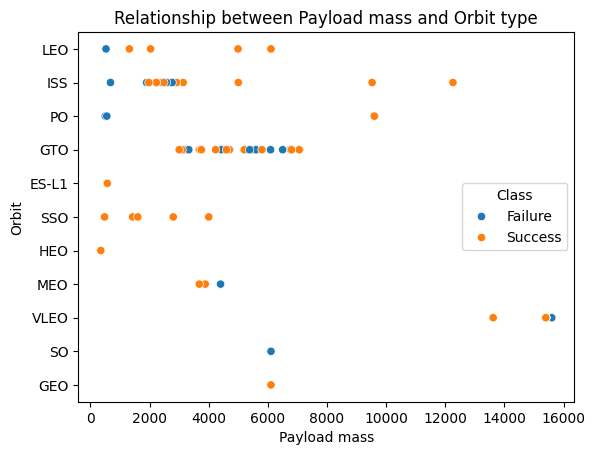

In [117]:
# Visualize relationship between Payload mass and Orbit type
sns.scatterplot(y='Orbit', x='PayloadMass', hue='Class', data=df)
plt.title('Relationship between Payload mass and Orbit type')
plt.xlabel('Payload mass')
plt.ylabel('Orbit')
# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = ['Failure', 'Success']  # Assuming 0 = Failure, 1 = Success
plt.legend(title='Class', handles=handles, labels=custom_labels, loc='center right')  # Skip automatic title

plt.show()

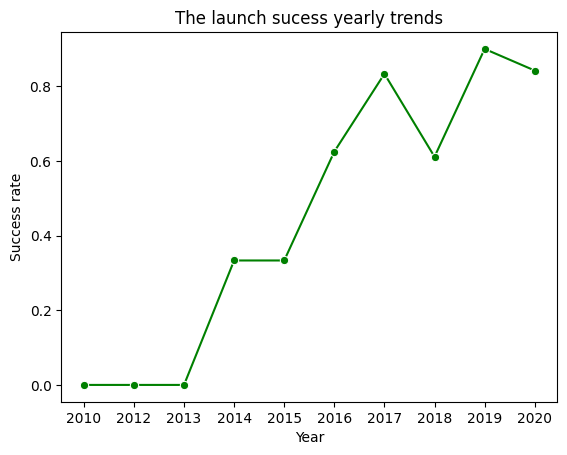

In [121]:
# Visualize the launch sucess yearly trends
# A function to Extract years from the date 
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Year'] = year

# Calculate average success rate each year
data=df.groupby('Year')['Class'].mean().reset_index()

sns.lineplot(y='Class', x='Year', data=data, marker='o', color='green')
plt.title('The launch sucess yearly trends')
plt.xlabel('Year')
plt.ylabel('Success rate')

plt.show()


### Features engeneering

In [123]:
# Determine features that can be used to predict launching outcome
features=df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Class']]
features.head()

FlightNumber  PayloadMass Orbit    LaunchSite  Flights  GridFins  Reused  \
0             1  6104.959412   LEO  CCAFS SLC 40        1     False   False   
1             2   525.000000   LEO  CCAFS SLC 40        1     False   False   
2             3   677.000000   ISS  CCAFS SLC 40        1     False   False   
3             4   500.000000    PO   VAFB SLC 4E        1     False   False   
4             5  3170.000000   GTO  CCAFS SLC 40        1     False   False   

    Legs LandingPad  Block  ReusedCount Serial  Class  
0  False        NaN    1.0            0  B0003      0  
1  False        NaN    1.0            0  B0005      0  
2  False        NaN    1.0            0  B0007      0  
3  False        NaN    1.0            0  B1003      0  
4  False        NaN    1.0            0  B1004      0

In [126]:
# Create dummy variables to categorical columns
# Apply one-hot encoding to specified columns
features_one_hot = pd.get_dummies(features, columns = list(features.select_dtypes(include=['object', 'category']).columns))

# Display the first few rows
features_one_hot.head()

FlightNumber  PayloadMass  Flights  GridFins  Reused   Legs  Block  \
0             1  6104.959412        1     False   False  False    1.0   
1             2   525.000000        1     False   False  False    1.0   
2             3   677.000000        1     False   False  False    1.0   
3             4   500.000000        1     False   False  False    1.0   
4             5  3170.000000        1     False   False  False    1.0   

   ReusedCount  Class  Orbit_ES-L1  Orbit_GEO  Orbit_GTO  Orbit_HEO  \
0            0      0        False      False      False      False   
1            0      0        False      False      False      False   
2            0      0        False      False      False      False   
3            0      0        False      False      False      False   
4            0      0        False      False       True      False   

   Orbit_ISS  Orbit_LEO  Orbit_MEO  Orbit_PO  Orbit_SO  Orbit_SSO  Orbit_VLEO  \
0      False       True      False     False     False      False       False   
1      False       True      False     False     False      False       False   
2       True      False      False     False     False      False       False   
3      False      False      False      True     False      False       False   
4      False      False      False     False     False      False       False   

   LaunchSite_CCAFS SLC 40  LaunchSite_KSC LC 39A  LaunchSite_VAFB SLC 4E  \
0                     True                  False                   False   
1                     True                  False                   False   
2                     True                  False                   False   
3                    False                  False                    True   
4                     True                  False                   False   

   LandingPad_5e9e3032383ecb267a34e7c7  LandingPad_5e9e3032383ecb554034e7c9  \
0                                False                                False   
1                                False                                False   
2                                False                                False   
3                                False                                False   
4                                False                                False   

   LandingPad_5e9e3032383ecb6bb234e7ca  LandingPad_5e9e3032383ecb761634e7cb  \
0                                False                                False   
1                                False                                False   
2                                False                                False   
3                                False                                False   
4                                False                                False   

   LandingPad_5e9e3033383ecbb9e534e7cc  Serial_B0003  Serial_B0005  \
0                                False          True         False   
1                                False         False          True   
2                                False         False         False   
3                                False         False         False   
4                                False         False         False   

   Serial_B0007  Serial_B1003  Serial_B1004  Serial_B1005  Serial_B1006  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2          True         False         False         False         False   
3         False          True         False         False         False   
4         False         False          True         False         False   

   Serial_B1007  Serial_B1008  Serial_B1010  Serial_B1011  Serial_B1012  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False        

In [130]:
# Transform all numerical variables to float64
features_one_hot=features_one_hot.astype('float64')
features_one_hot['Class']=features_one_hot['Class'].astype(int)
features_one_hot.head()

FlightNumber  PayloadMass  Flights  GridFins  Reused  Legs  Block  \
0           1.0  6104.959412      1.0       0.0     0.0   0.0    1.0   
1           2.0   525.000000      1.0       0.0     0.0   0.0    1.0   
2           3.0   677.000000      1.0       0.0     0.0   0.0    1.0   
3           4.0   500.000000      1.0       0.0     0.0   0.0    1.0   
4           5.0  3170.000000      1.0       0.0     0.0   0.0    1.0   

   ReusedCount  Class  Orbit_ES-L1  Orbit_GEO  Orbit_GTO  Orbit_HEO  \
0          0.0      0          0.0        0.0        0.0        0.0   
1          0.0      0          0.0        0.0        0.0        0.0   
2          0.0      0          0.0        0.0        0.0        0.0   
3          0.0      0          0.0        0.0        0.0        0.0   
4          0.0      0          0.0        0.0        1.0        0.0   

   Orbit_ISS  Orbit_LEO  Orbit_MEO  Orbit_PO  Orbit_SO  Orbit_SSO  Orbit_VLEO  \
0        0.0        1.0        0.0       0.0       0.0        0.0         0.0   
1        0.0        1.0        0.0       0.0       0.0        0.0         0.0   
2        1.0        0.0        0.0       0.0       0.0        0.0         0.0   
3        0.0        0.0        0.0       1.0       0.0        0.0         0.0   
4        0.0        0.0        0.0       0.0       0.0        0.0         0.0   

   LaunchSite_CCAFS SLC 40  LaunchSite_KSC LC 39A  LaunchSite_VAFB SLC 4E  \
0                      1.0                    0.0                     0.0   
1                      1.0                    0.0                     0.0   
2                      1.0                    0.0                     0.0   
3                      0.0                    0.0                     1.0   
4                      1.0                    0.0                     0.0   

   LandingPad_5e9e3032383ecb267a34e7c7  LandingPad_5e9e3032383ecb554034e7c9  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   LandingPad_5e9e3032383ecb6bb234e7ca  LandingPad_5e9e3032383ecb761634e7cb  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   LandingPad_5e9e3033383ecbb9e534e7cc  Serial_B0003  Serial_B0005  \
0                                  0.0           1.0           0.0   
1                                  0.0           0.0           1.0   
2                                  0.0           0.0           0.0   
3                                  0.0           0.0           0.0   
4                                  0.0           0.0           0.0   

   Serial_B0007  Serial_B1003  Serial_B1004  Serial_B1005  Serial_B1006  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           1.0           0.0           0.0           0.0           0.0   
3           0.0           1.0           0.0           0.0           0.0   
4           0.0           0.0           1.0           0.0           0.0   

   Serial_B1007  Serial_B1008  Serial_B1010  Serial_B1011  Serial_B1012  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0

In [131]:
features_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   FlightNumber                         90 non-null     float64
 1   PayloadMass                          90 non-null     float64
 2   Flights                              90 non-null     float64
 3   GridFins                             90 non-null     float64
 4   Reused                               90 non-null     float64
 5   Legs                                 90 non-null     float64
 6   Block                                90 non-null     float64
 7   ReusedCount                          90 non-null     float64
 8   Class                                90 non-null     int64  
 9   Orbit_ES-L1                          90 non-null     float64
 10  Orbit_GEO                            90 non-null     float64
 11  Orbit_GTO                         

In [133]:
# Save file to csv
# Explort dataset into csv format
path=r'C:\Users\USER\OneDrive - University of Global Health Equity\Documents\PERSONAL DOCUMENTS\PERSONAL DEVELOPMENT\IBM DATA SCIENCE\Key projects\Applied Data Science Capstone\dataset_part_3.csv'
features_one_hot.to_csv(path, index=False)
print('File saved successfuly')

File saved successfuly


# Interactive visual analytics with Folium

## Objectives

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

In [13]:
# Import dataset
url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
df=pd.read_csv(url)

# Extract only launchsites, lat, long, and Class
spacex_df=df[['Launch Site', 'Lat', 'Long', 'class']]

# Group launchsites together
LSdf=spacex_df.groupby(['Launch Site'], as_index=False).first()
LSdf=LSdf[['Launch Site', 'Lat', 'Long']]
LSdf.head()

Launch Site        Lat        Long
0   CCAFS LC-40  28.562302  -80.577356
1  CCAFS SLC-40  28.563197  -80.576820
2    KSC LC-39A  28.573255  -80.646895
3   VAFB SLC-4E  34.632834 -120.610745

In [22]:
# Start map at NASA Johson Space Center
nasa=[29.559684888503615, -95.0830971930759]
site_map=folium.Map(location=nasa, zoom_start=10)

# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle=folium.Circle(nasa, radius=1000, color='#d35400', fill=True, fill_color='yellow').add_child(folium.Popup('NASA Johnson Space Center'))

# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker=folium.map.Marker(
    nasa,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
    )
)

site_map.add_child(circle)
site_map.add_child(marker)
site_map

In [40]:
# Add all launchsites
# Initil map
site_map = folium.Map(location=nasa, zoom_start=5)

# Loop through each launch site
for _, row in LSdf.iterrows():
    location = [row['Lat'], row['Long']]
    name = row['Launch Site']

    # Add circle
    circle1 = folium.Circle(
        location,
        radius=100,
        color='#d35400',
        fill=True,
        fill_color='yellow'
    ).add_child(folium.Popup(name))

    # Add label marker
    marker1 = folium.map.Marker(
        location,
        icon=DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 12px; color:#d35400;"><b>{name}</b></div>',
        )
    )

    site_map.add_child(circle1)
    site_map.add_child(marker1)

# Display map
site_map

**Falcon 9 launch sites are located near U.S. coastlines and closer to the equator to maximize fuel efficiency, ensure safety, and support a wide range of orbital trajectories.**

### 🚀 1. **Boost from Earth’s Rotation (Equatorial Advantage)**
- The Earth rotates fastest at the equator — about **1,670 km/h (1,037 mph)**.
- Launching **eastward** from a site closer to the equator gives rockets a **free velocity boost**, reducing the fuel needed to reach orbit.
- This is especially beneficial for **low-inclination orbits** like geostationary or equatorial orbits.

---

### 🌊 2. **Safety Over Oceans**
- Falcon 9 launches involve **staging events** and sometimes **booster landings**.
- Launching from **coastal sites** ensures that any debris or failed stages fall into the **Atlantic or Pacific Ocean**, not populated areas.
- This is a key reason why **Cape Canaveral (Florida)** and **Vandenberg (California)** are favored.

---

### 🌍 3. **Access to Diverse Orbits**
- **East Coast (Florida)**: Ideal for **equatorial and geostationary orbits** due to its eastern coastline and proximity to the equator.
- **West Coast (California)**: Best for **polar and sun-synchronous orbits**, which require launching southward over the ocean.
- This dual-coast strategy allows SpaceX to serve a **wide range of missions** from U.S. territory.

---

### 🧪 4. **Infrastructure and Logistics**
- Launch sites like **Kennedy Space Center (LC-39A)** and **Cape Canaveral (SLC-40)** already had decades of NASA and Air Force infrastructure.
- Proximity to SpaceX’s **manufacturing and testing facilities** in Texas and California simplifies logistics and reduces costs.

---

### 🛰️ 5. **Launch Corridor Clearance**
- Launch sites must have **clear, uninhabited corridors** in the direction of flight.
- Coastal locations naturally provide this, minimizing risk to people and property in case of anomalies.


**Sources:**
- [ScienceABC – Why launch near the equator](https://www.scienceabc.com/eyeopeners/why-are-rockets-launched-from-areas-near-the-equator.html)
- [Wikipedia – SpaceX facilities](https://en.wikipedia.org/wiki/SpaceX_facilities)
- [NASASpaceFlight Forum – Launch site selection](https://forum.nasaspaceflight.com/index.php?topic=60269.0)



In [41]:
# Add launch outcome to the map
marker_cluster=MarkerCluster()

# Create new column in spacex_df with green reprsenting success and red representing failure

# Initialize an empty list to store colors
colors = []

# Loop through each value in the 'class' column
for Class in spacex_df['class']:
    if Class == 1:
        colors.append('green')
    else:
        colors.append('red')

# Assign the list to a new column
spacex_df['Class_Color'] = colors

# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# For each launch result in spacex_df add folium marker to marker_cluster
for index, record in spacex_df.iterrows():
    location=[record['Lat'], record['Long']]
    icon_color=record['Class_Color']
    outcome='Success' if record['class']==1 else 'Failure'
    popup_text=f'Launch Outcome: {outcome}'
    
    
    # TODO: Create and add a Marker cluster to the site map
    marker3 = folium.Marker(location=location,
                            popup=folium.Popup(popup_text, max_width=200),
                            icon=folium.Icon(color=icon_color, icon='rocket', prefix='fa')
        )

    # Add marker to th cluster
    marker_cluster.add_child(marker3)

site_map

C:\Users\USER\AppData\Local\Temp\ipykernel_13388\2713002375.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacex_df['Class_Color'] = colors


### Calculate the distance between a launchsite to its proximity


In [42]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.

In [43]:
# Define function to calculate distance
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [44]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

# Calculate the distance between CCAFS-SLC-40
distance_coastline=f'{np.round(calculate_distance(28.563193, -80.576820, 28.56488, -80.58748),2)}Km'
distance_coastline

'1.06Km'

In [45]:
# Calculate distance using Geopy library

launchsite_CCAFS_LC_40=(28.562302,-80.577356)
coastline=(28.56488, -80.58748)
distance=geodesic(launchsite_CCAFS_LC_40, coastline).km

# Create a marker with a styled label and a popup
distance_marker = folium.Marker(
    location=[28.56488, -80.58748],
    icon=DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html='<div style="font-size: 12px; color:#d35400;"><b>{:10.2f} KM</b></div>'.format(distance),
    ),
    popup=folium.Popup(f'Distance to Launch Site (CCAFS_LC_40): {distance:.2f} KM', max_width=200)
)

# Add to map
site_map.add_child(distance_marker)
site_map

In [47]:
# TODO: Draw a PolyLine between a launch site to the selected coastline point

# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
launch_site_coord = [28.562302, -80.577356]     # Example: CCAFS LC-40
coastline_coord = [28.56488, -80.58748]         # Example: closest coastline point
coordinates = [launch_site_coord, coastline_coord]
lines=folium.PolyLine(locations=coordinates, weight=2)
site_map.add_child(lines)
site_map

# Building an Interactive Dashboard with plotly dash

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from dash import no_update
import datetime as dt

# Import dataset
url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv'
df=pd.read_csv(url)
df.drop('Unnamed: 0', axis=1, inplace=True)
max_payload = df['Payload Mass (kg)'].max()
min_payload = df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                dcc.Dropdown(id='site-dropdown',
                                            options=[{'label': 'All Sites', 'value':'All Sites'},
                                                    {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                                    {'label': 'VAFB SLC-4E',  'value': 'VAFB SLC-4E'},
                                                    {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                                    {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}],
                                            value='All Sites', placeholder='Select a Launch Site Here', searchable=True),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',
                                               min=0,
                                                max=10000,
                                               step=1000,
                                               value=[min_payload, max_payload]),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
             Input(component_id='site-dropdown', component_property='value'))

# Define function to return pie chart
def get_pie_chart(entered_site):
    data=df.groupby('Launch Site')['class'].mean().reset_index()
    if entered_site=='All Sites':
        fig1=px.pie(data, values='class', names='Launch Site', title='Success rate for all sites')
        fig1.update_layout(legend_title_text='Launch Site')
        return fig1
    elif entered_site in data['Launch Site'].unique():
        filtered_data=df[df['Launch Site']==entered_site]
        class_count=filtered_data['class'].value_counts().reset_index()
        class_count.columns=['class', 'count']
        class_count['class']=class_count['class'].map({1: 'Success', 0: 'Failure'})
        fig2=px.pie(class_count, values='count', names='class', title=f'Success rate for {entered_site}')
        
        # Customize legend
        fig2.update_layout(
    legend_title_text='Launch Outcome',
    legend=dict(
        orientation='v',
        x=1.05,
        y=1,
        font=dict(size=12, color='black')
    )
)

        return fig2

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
             [Input(component_id='site-dropdown', component_property='value'),
              Input(component_id='payload-slider', component_property='value')]
    
)

# Define a function to generate scatter plot
def get_scatter_plot(entered_site, payload_range):
    low, high = payload_range
    filtered_df = df[(df['Payload Mass (kg)'] >= low) & (df['Payload Mass (kg)'] <= high)]

    if entered_site == 'All Sites':
        fig3 = px.scatter(
            filtered_df,
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version',
            title='Correlation between Payload Mass and Success Rate for All Sites'
        )
        return fig3
    else:
        site_df = filtered_df[filtered_df['Launch Site'] == entered_site]
        fig4 = px.scatter(
            site_df,
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version',
            title=f'Correlation between Payload and Success Rate for {entered_site}'
        )
        return fig4

# Run the app
if __name__ == '__main__':
    app.run()

In [83]:
path=r'C:\Users\USER\OneDrive - University of Global Health Equity\Documents\PERSONAL DOCUMENTS\PERSONAL DEVELOPMENT\IBM DATA SCIENCE\Key projects\Dashboards\Falcon 9 launch\spacex_launch_dash.csv'
df.to_csv(path)
print('Done')

Done


# Space X Falcon 9 First Stage Landing Prediction

## Objectives

Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

* Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data

In [7]:
# Import dataset for EDA
url1="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df1=pd.read_csv(url1)
df1.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  Class  
0            0  B0003  -80.577366  28.561857      0  
1            0  B0005  -80.577366  28.561857      0  
2            0  B0007  -80.577366  28.561857      0  
3            0  B1003 -120.610829  34.632093      0  
4            0  B1004  -80.577366  28.561857      0

In [8]:
# Import dataset for predictive analysis
url2= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
df2=pd.read_csv(url2)
df2.head()

FlightNumber  PayloadMass  Flights  Block  ReusedCount  Orbit_ES-L1  \
0           1.0  6104.959412      1.0    1.0          0.0          0.0   
1           2.0   525.000000      1.0    1.0          0.0          0.0   
2           3.0   677.000000      1.0    1.0          0.0          0.0   
3           4.0   500.000000      1.0    1.0          0.0          0.0   
4           5.0  3170.000000      1.0    1.0          0.0          0.0   

   Orbit_GEO  Orbit_GTO  Orbit_HEO  Orbit_ISS  Orbit_LEO  Orbit_MEO  Orbit_PO  \
0        0.0        0.0        0.0        0.0        1.0        0.0       0.0   
1        0.0        0.0        0.0        0.0        1.0        0.0       0.0   
2        0.0        0.0        0.0        1.0        0.0        0.0       0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0       1.0   
4        0.0        1.0        0.0        0.0        0.0        0.0       0.0   

   Orbit_SO  Orbit_SSO  Orbit_VLEO  LaunchSite_CCAFS SLC 40  \
0       0.0        0.0         0.0                      1.0   
1       0.0        0.0         0.0                      1.0   
2       0.0        0.0         0.0                      1.0   
3       0.0        0.0         0.0                      0.0   
4       0.0        0.0         0.0                      1.0   

   LaunchSite_KSC LC 39A  LaunchSite_VAFB SLC 4E  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                    0.0                     0.0   
3                    0.0                     1.0   
4                    0.0                     0.0   

   LandingPad_5e9e3032383ecb267a34e7c7  LandingPad_5e9e3032383ecb554034e7c9  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   LandingPad_5e9e3032383ecb6bb234e7ca  LandingPad_5e9e3032383ecb761634e7cb  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   LandingPad_5e9e3033383ecbb9e534e7cc  Serial_B0003  Serial_B0005  \
0                                  0.0           1.0           0.0   
1                                  0.0           0.0           1.0   
2                                  0.0           0.0           0.0   
3                                  0.0           0.0           0.0   
4                                  0.0           0.0           0.0   

   Serial_B0007  Serial_B1003  Serial_B1004  Serial_B1005  Serial_B1006  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           1.0           0.0           0.0           0.0           0.0   
3           0.0           1.0           0.0           0.0           0.0   
4           0.0           0.0           1.0           0.0           0.0   

   Serial_B1007  Serial_B1008  Serial_B1010  Serial_B1011  Serial_B1012  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   Serial_B1013  Serial_B1015  Serial_B1016  Serial_B1017  Serial_B1018  \
0           0.0           0.0  

In [40]:
# Define input and output variables
y=df1['Class']
x=df2

# Split dataset into train and test
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=42, stratify=y)

# Build a pipeline
pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Determine parameters grid
param_grid={
    'classifier__C': [0.01,0.1,1],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__solver': ['lbfgs'] # For small to medium datasets
}

# Determine cross-validation parameters
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Grid search
model=GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

# Fit the model
model.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['lbfgs']},
             scoring='accuracy', verbose=2)

In [43]:
# print the best hyperparameters and accuracy score
yhat=model.predict(x_test)

print('Tuned hyperparameters :(Best parameters', model.best_params_)
print(f'\nAccuracy Score during training: {np.round(model.best_score_,2)}')
print(f'\nClassification report for test data: \n\n{classification_report(y_test, yhat)}')

Tuned hyperparameters :(Best parameters {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Accuracy Score during training: 0.85

Classification report for test data: 

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



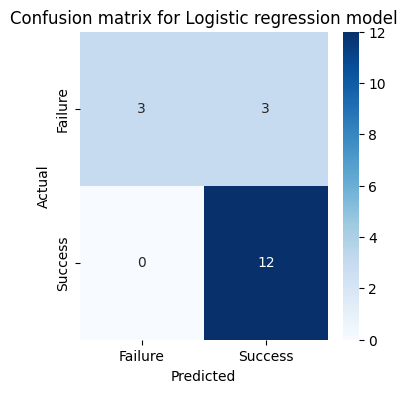

In [44]:
# Plot the confusion matrix
conf_matrix=confusion_matrix(y_test, yhat)
label=['Failure', 'Success']
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label, yticklabels=label)
plt.title('Confusion matrix for Logistic regression model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

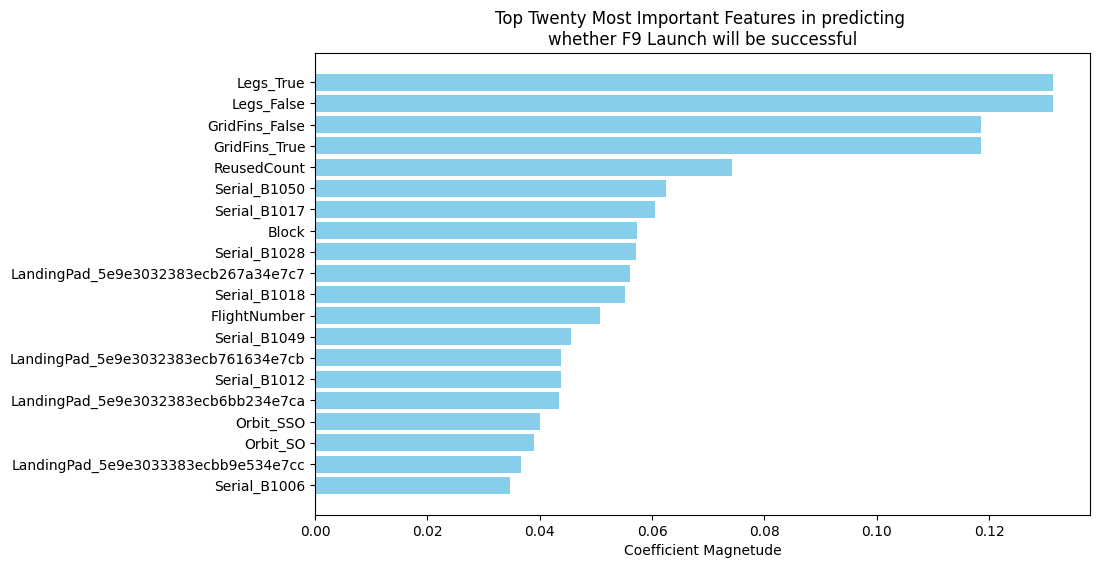

In [45]:
# Extract and plot feature importance

# determine feature names
feature_names=x_train.columns.tolist()

# Determine feature importances
feature_importance=model.best_estimator_.named_steps['classifier'].coef_[0]

# Create the dataframe for feature names and their importance
df_imp=pd.DataFrame({'Feature': feature_names,
             'Importance': feature_importance
             }).sort_values(by='Importance', ascending=False, key=abs)

# Determine top 10 features
top20_features=df_imp.head(20)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top20_features['Feature'], top20_features['Importance'].abs(), color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top Twenty Most Important Features in predicting \nwhether F9 Launch will be successful')
plt.xlabel('Coefficient Magnetude')
plt.show()

### Use Support vector machine as a model

In [46]:
# Replace classifier to Support Vector Classifier (SVC)
pipeline.set_params(classifier=SVC())

# Update pipeline
model.estimator=pipeline

# define new parameters for SVC
param_grid={'classifier__kernel':('linear', 'rbf','poly', 'sigmoid'),
              'classifier__C': np.logspace(-3, 3, 5),
              'classifier__gamma':np.logspace(-3, 3, 5)}

# Update param_grid
model.param_grid=param_grid

# fit the model
model.fit(x_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'classifier__gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'classifier__kernel': ('linear', 'rbf', 'poly',
                                                'sigmoid')},
             scoring='accuracy', verbose=2)

In [47]:

# Get prediction, best parameters and metrics
yhat=model.predict(x_test)

print('Tuned hyperparameters :(Best parameters)', model.best_params_)
print(f'\nAccuracy Score during training: {np.round(model.best_score_,2)}')
print(f'\nClassification report for testing data: \n\n{classification_report(y_test, yhat)}')

Tuned hyperparameters :(Best parameters) {'classifier__C': np.float64(1.0), 'classifier__gamma': np.float64(0.001), 'classifier__kernel': 'linear'}

Accuracy Score during training: 0.85

Classification report for testing data: 

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.75      0.75      0.75        12

    accuracy                           0.67        18
   macro avg       0.62      0.62      0.62        18
weighted avg       0.67      0.67      0.67        18



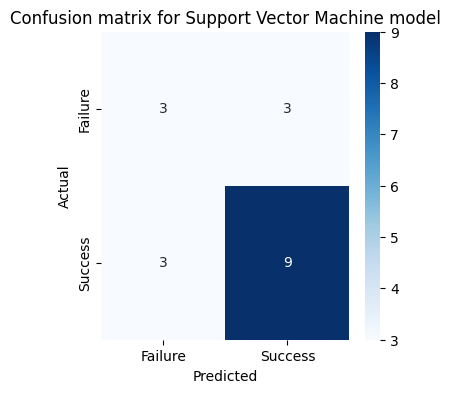

In [48]:
# Plot confusion matrix
# Plot the confusion matrix
conf_matrix=confusion_matrix(y_test, yhat)
label=['Failure', 'Success']
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label, yticklabels=label)
plt.title('Confusion matrix for Support Vector Machine model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

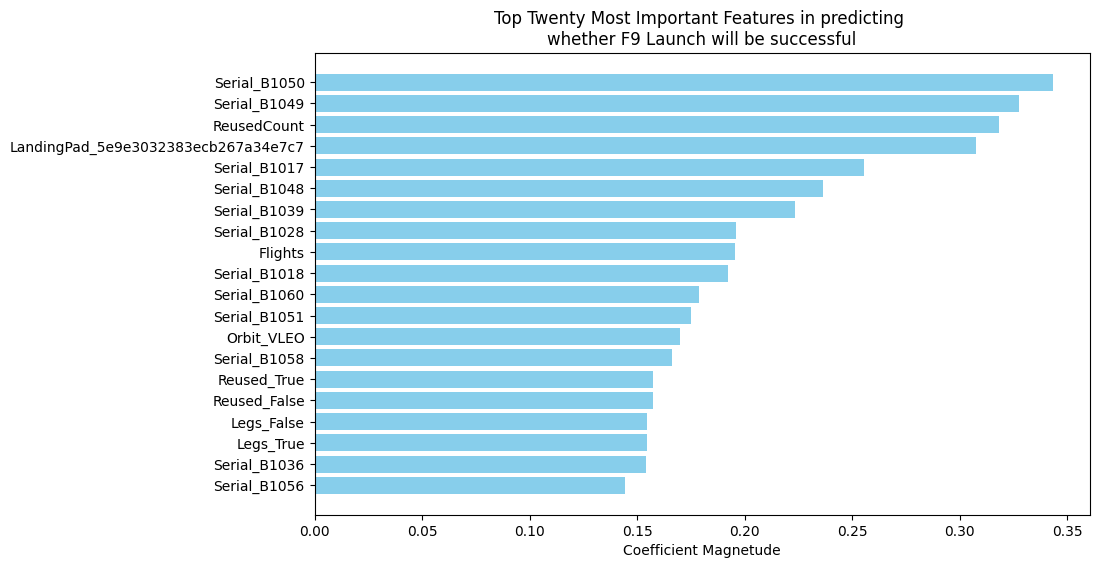

In [49]:
# Extract and plot feature importance

# determine feature names
feature_names=x_train.columns.tolist()

# Determine feature importances
feature_importance=model.best_estimator_.named_steps['classifier'].coef_[0]

# Create the dataframe for feature names and their importance
df_imp=pd.DataFrame({'Feature': feature_names,
             'Importance': feature_importance
             }).sort_values(by='Importance', ascending=False, key=abs)

# Determine top 10 features
top20_features=df_imp.head(20)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top20_features['Feature'], top20_features['Importance'].abs(), color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top Twenty Most Important Features in predicting \nwhether F9 Launch will be successful')
plt.xlabel('Coefficient Magnetude')
plt.show()

### Using decision tree classifier to build a model

In [52]:
# Replace classifier to Decision Tree Classifier
pipeline.set_params(classifier=DecisionTreeClassifier())

# Update pipeline
model.estimator=pipeline

# define new parameters for DTC
param_grid={'classifier__criterion': ['gini', 'entropy'],
     'classifier__splitter': ['best', 'random'],
     'classifier__max_depth': [2*n for n in range(1,10)],
     'classifier__max_features': ['auto', 'sqrt'],
     'classifier__min_samples_leaf': [1, 2, 4],
     'classifier__min_samples_split': [2, 5, 10]}

# Update param_grid
model.param_grid=param_grid

# fit the model
model.fit(x_train, y_train)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=2, classifier__max_features=auto, classifier__min_samples_lea

C:\Users\USER\anaconda3\envs\PR_Env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


1620 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\PR_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\envs\PR_Env\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\USER\anaconda3\envs\PR_Env\Lib\site-packages\sklearn\pipeline.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [2, 4, 6, 8, 10, 12, 14, 16,
                                                   18],
                         'classifier__max_features': ['auto', 'sqrt'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__splitter': ['best', 'random']},
             scoring='accuracy', verbose=2)

In [53]:

# Get prediction, best parameters and metrics
yhat=model.predict(x_test)

print('Tuned hyperparameters :(Best parameters)', model.best_params_)
print(f'\nAccuracy Score during training: {np.round(model.best_score_,2)}')
print(f'\nClassification report for testing data: \n\n{classification_report(y_test, yhat)}')

Tuned hyperparameters :(Best parameters) {'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__splitter': 'random'}

Accuracy Score during training: 0.9

Classification report for testing data: 

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.75      1.00      0.86        12

    accuracy                           0.78        18
   macro avg       0.88      0.67      0.68        18
weighted avg       0.83      0.78      0.74        18



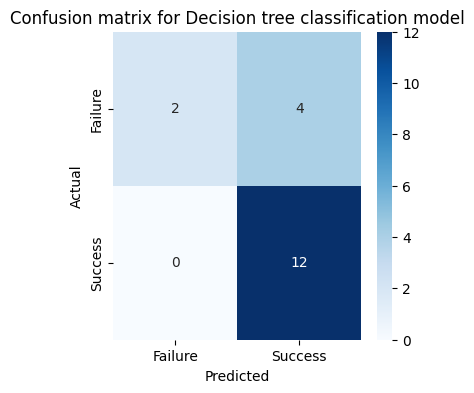

In [54]:
# Plot the confusion matrix
conf_matrix=confusion_matrix(y_test, yhat)
label=['Failure', 'Success']
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label, yticklabels=label)
plt.title('Confusion matrix for Decision tree classification model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

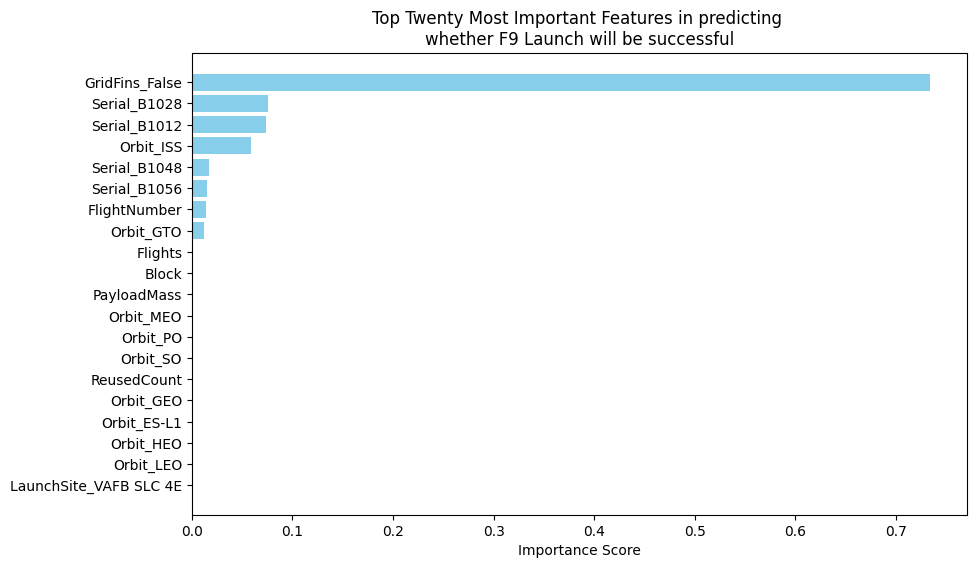

In [55]:
# Extract and plot feature importance

# determine feature names
feature_names=x_train.columns.tolist()

# Determine feature importances
feature_importance=model.best_estimator_.named_steps['classifier'].feature_importances_

# Create the dataframe for feature names and their importance
df_imp=pd.DataFrame({'Feature': feature_names,
             'Importance': feature_importance
             }).sort_values(by='Importance', ascending=False)

# Determine top 10 features
top20_features=df_imp.head(20)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top20_features['Feature'], top20_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top Twenty Most Important Features in predicting \nwhether F9 Launch will be successful')
plt.xlabel('Importance Score')
plt.show()

### Use K nearest neighbor model

In [56]:
# Replace classifier to K nearest neighbor model
pipeline.set_params(classifier=KNeighborsClassifier())

# Update pipeline
model.estimator=pipeline

# define new parameters for KNN
param_grid={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'classifier__p': [1,2]}

# Update param_grid
model.param_grid=param_grid

# fit the model
model.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\USER\anaconda3\envs\PR_Env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=1; total time=   5.8s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=1; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=1; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=1; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=1; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=2; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=2; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=2; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=2; total time=   0.0s
[CV] END classifier__algorithm=auto, classifier__n_neighbors=1, classifier__p=2; total time=   0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__algorithm': ['auto', 'ball_tree',
                                                   'kd_tree', 'brute'],
                         'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10],
                         'classifier__p': [1, 2]},
             scoring='accuracy', verbose=2)

In [57]:

# Get prediction, best parameters and metrics
yhat=model.predict(x_test)

print('Tuned hyperparameters :(Best parameters)', model.best_params_)
print(f'\nAccuracy Score during training: {np.round(model.best_score_,2)}')
print(f'\nClassification report for testing data: \n\n{classification_report(y_test, yhat)}')

Tuned hyperparameters :(Best parameters) {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 6, 'classifier__p': 1}

Accuracy Score during training: 0.88

Classification report for testing data: 

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.75      1.00      0.86        12

    accuracy                           0.78        18
   macro avg       0.88      0.67      0.68        18
weighted avg       0.83      0.78      0.74        18



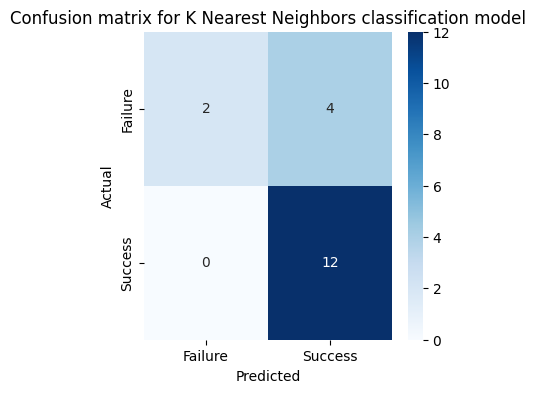

In [58]:
# Plot the confusion matrix
conf_matrix=confusion_matrix(y_test, yhat)
label=['Failure', 'Success']
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label, yticklabels=label)
plt.title('Confusion matrix for K Nearest Neighbors classification model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Best model

Based on models metrics, **Logistic Regression** is the best model as it has 100% true positive and 50% True negative. However, no other model had these best metrics as most others had poor True negative/True positive values that logistic regression

In [60]:
x_test.shape

(18, 83)

In [61]:
y_test.shape

(18,)